# First Experiments
* 3 base models
* Std_Norm
* No data augmentatition
* MSE

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ResNet-Autoencoder" data-toc-modified-id="ResNet-Autoencoder-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ResNet Autoencoder</a></span><ul class="toc-item"><li><span><a href="#Architecture-definition" data-toc-modified-id="Architecture-definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Architecture definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training</a></span></li></ul></li></ul></div>

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

In [1]:
import os
import glob
import tensorflow as tf
import random
from my_tf_data_loader_optimized import tf_data_png_loader

GLOBAL_BATCH_SIZE = 16
train_percentage = 0.85
INPUT_SHAPE = (128,128)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## ResNet Autoencoder

### Architecture definition

In [2]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, BatchNormalization, Add, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def relu_bn(inputs: Tensor, name='RB') -> Tensor:
    y = BatchNormalization(name=name+'inner_BN')(inputs) 
    return ReLU(name=name+'_innerReLu')(y)

def residual_block(x: Tensor, filters, ks = (3,3), stride = 2, name='RB'):
    y = Conv2D(filters= filters,
               kernel_size= ks,
               strides= stride,              
               padding="same",
               name=name+'_C1')(x)
    
    y = relu_bn(y, name=name)
    
    y = Conv2D(filters= filters,
               kernel_size= ks,
               strides= 1,               
               padding="same",
               name=name+'_C2')(y)
    y = BatchNormalization(name=name+'_BN')(y) 
    
    if stride !=1:
        x = Conv2D(filters = filters,
                   kernel_size= (1,1),
                   strides= stride,
                   padding="same",
                   name=name+'_CAdjust')(x)
        x = BatchNormalization(name=name+'_BNAdjust')(x) 
    
    y = Add(name=name+'_ResSUM')([x,y])
    y =  ReLU(name=name+'_ReLu')(y)
    return y

def upsampling_block(x: Tensor, filters, ks=(3,3), name='UP'):
    '''y = Conv2D(filters, ks, activation='relu', padding='same', name=name+'_C1')(x) #474k
    y = BatchNormalization(name=name+'_BN')(y) 
    y = UpSampling2D((2, 2), name=name+'_Up')(y)'''
    
    y = Conv2DTranspose(filters, ks, strides=(2,2), padding='same', name=name+'_C1')(x) #474k
    y = BatchNormalization(name=name+'_BN')(y) 
    y =  ReLU(name=name+'_ReLu')(y)
    return y
    

def build_res_encoder(input_shape):
    #INPUT
    input_img = Input(shape = input_shape)
    
    #ENCODER
    x = Conv2D(32, (3,3), strides= 2, padding="same", name='Conv1')(input_img) #/2*/2*32
    x = residual_block(x, 64, name='RB1') #64*64*64
    x = residual_block(x, 64, stride=1, name='RB2_same_dim') #/4*/4*64
    x = MaxPooling2D((2,2))(x) #/8*/8*64
    x = residual_block(x, 128, stride=2, name='RB3') #/16*/16*128
    
    #DECODER
    y = upsampling_block(x,64, name='UP1') #/8*/8*64
    y = upsampling_block(y,32, name='UP2') #/4*/4*32
    y = upsampling_block(y,32, name='UP3') #/2*/2*16
    y = upsampling_block(y,32, name='UP4') #1.*1.*8
    decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(y)
    return Model(input_img, decoded)
    

In [3]:
res_autoencoder =  build_res_encoder(INPUT_SHAPE+(1,))   
res_autoencoder.compile(loss='mse', optimizer='Adam')
res_autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
RB1_C1 (Conv2D)                 (None, 32, 32, 64)   18496       Conv1[0][0]                      
__________________________________________________________________________________________________
RB1inner_BN (BatchNormalization (None, 32, 32, 64)   256         RB1_C1[0][0]                     
_______________________________________________________________________________________

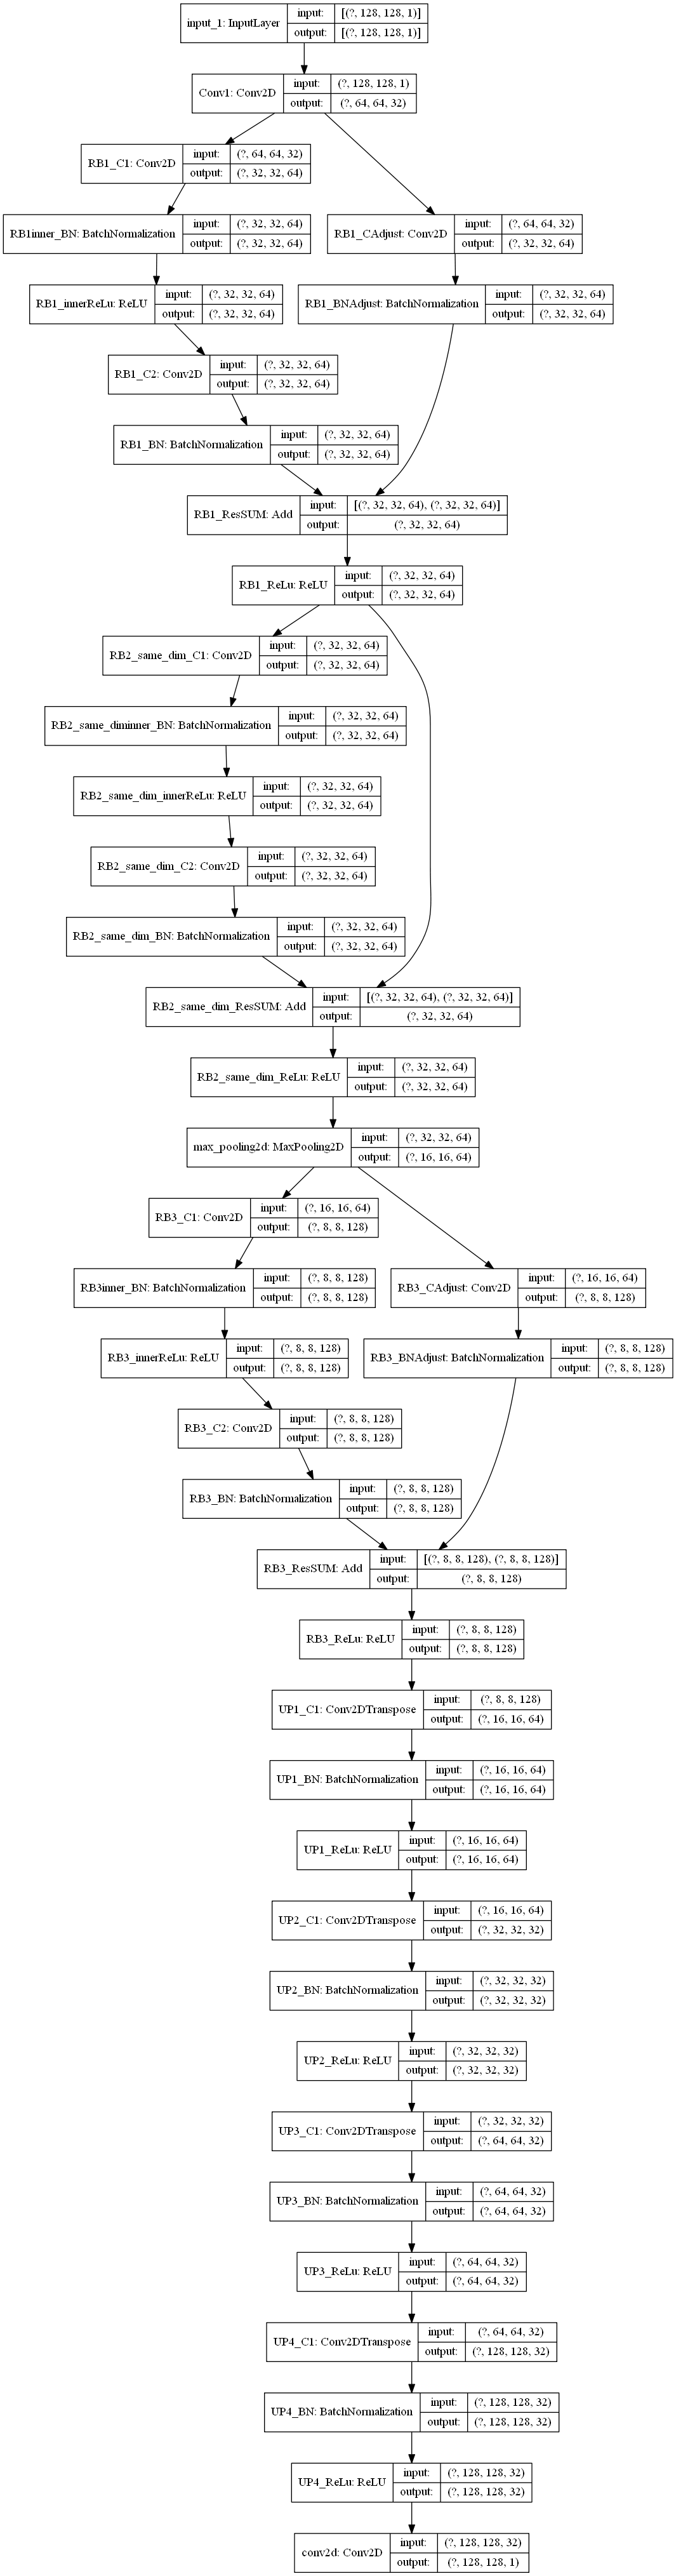

In [4]:
plot_model(res_autoencoder, to_file='logs/res_cae_0.png', show_shapes=True)

### Training

In [5]:
MAIN_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'train_val_folder'+os.path.sep+'train_and_val'
trainval_img_files = glob.glob(MAIN_img_PATH+os.path.sep+'*.png')
random.shuffle(trainval_img_files)

lim = int(len(trainval_img_files)*train_percentage)
train_img_files = trainval_img_files[:lim]
validation_img_files = trainval_img_files[lim:]

params = {'batch_size': GLOBAL_BATCH_SIZE,
          'cache':False,
          'shuffle_buffer_size':1000,
          'resize':INPUT_SHAPE
         }

train_loader = tf_data_png_loader(train_img_files, **params)
train_ds = train_loader.get_tf_ds_generator()

validation_loader = tf_data_png_loader(validation_img_files, **params)
validation_ds = validation_loader.get_tf_ds_generator()

STEP_SIZE_TRAIN = len(train_img_files) // train_loader.batch_size
STEP_SIZE_VALID = len(validation_img_files) // validation_loader.batch_size

In [6]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard

my_callbacks = [CSVLogger('./logs/res_cae_0_csvlogger.csv', separator=";", append=False),
                ModelCheckpoint(filepath='./logs/res_based_ae_model.h5', #.{epoch:02d}-{val_loss:.2f}
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                               )
               ]
                


In [27]:
autoencoder =  build_res_encoder(INPUT_SHAPE+(1,))#,  params.get('batch_size'))   
autoencoder.compile(loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.RMSprop())
history = autoencoder_train = autoencoder.fit(train_ds,
                                              epochs=2,
                                              #batch_size=train_loader.batch_size,
                                              steps_per_epoch = STEP_SIZE_TRAIN,
                                              validation_data = validation_ds, 
                                              validation_steps = STEP_SIZE_VALID,
                                              verbose=1,
                                              callbacks = my_callbacks,
                                              max_queue_size = 50
                                             )

Epoch 1/2
 265/2892 [=>............................] - ETA: 1:11 - loss: 0.5813

KeyboardInterrupt: 

In [8]:
TEST_img_PATH = '..'+os.path.sep+'IXI-T1'+os.path.sep+'PNG'+os.path.sep+'test_folder'+os.path.sep+'test'
test_img_files = glob.glob(MAIN_img_PATH+os.path.sep+'*.png')

test_ds = tf_data_png_loader(test_img_files,
                             **params,
                             train=False
                            ).get_tf_ds_generator()


NameError: name 'new_model' is not defined

In [9]:
for e in test_ds.take(1):
    pass

In [ ]:
new_model.summary()

In [17]:
import matplotlib.pyplot as plt

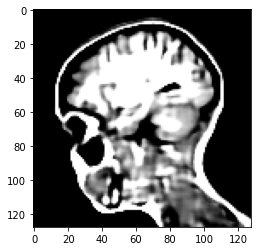

In [22]:
plt.imshow(autoencoder.predict(tf.expand_dims(e[0][0], axis=0))[0], cmap='gray')

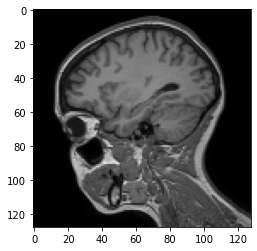

In [25]:
plt.imshow(e[1][0], cmap='gray')

<tf.Tensor: shape=(1, 128, 128, 1), dtype=float32, numpy=
array([[[[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ]],

        [[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ]],

        [[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ]],

        ...,

        [[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [ 0.994355  ],
         [ 1.5141625 ],
         [ 1.634926  ]],

        [[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [ 0.9838537 ],
         [ 1.0468607 ],
         [ 0.91559625]],

        [[-1.0428704 ],
         [-1.0428704 ],
         [-1.0428704 ],
         ...,
         [ 1.0206078 ],
         [ 0.87884